# 1. 기본 설정
## (1) 라이브러리 로드

In [1]:
import time
start_time = time.time()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# seaborn
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor
import copy

from datetime import datetime

## (2) 파라미터 설정

In [2]:
# EDA 파라미터

transform_contract_until = False    # 범주데이터인 계약기간('contract_until')을 연 단위에서 월 단위로 변경.
transform_position = True          # 범주데이터인 'position'을 시장 수요 공급에 따라 가중치 부여.

if transform_position == True:    # 포지션 가중치화시 시장 수요를 포메이션에 따라 결정. [3,5,2], [4,4,2] 등. 필요시 추가.
    formation = [3, 5, 2]          
    #formation = [4, 4, 2]
    #formation = [3, 6, 1]
    
transform_prefer_foot = True       # 범주데이터인 선호 발을 원핫 인코딩(left = 1, right = 0)으로 변경. 
transform_age = True               # 수치데이터이지만 피크값이 가운데에 있는 나이('age')를 오른쪽 끝으로 변경.

remove_continent = False            # 범주데이터인 출신 대륙('contient')이 충분한 지표가 되지 않는다고 예상하여 삭제. #false는 원핫 인코딩.
remove_stat_skill_moves = False     # 수치데이터인 'stat_skill_moves'가 'value'와 큰 관련성이 없다고 예상하여 삭제.

remove_outlier = True              # 'value' 기준 정렬 후, feature에 비해 높은/낮은 'value'가 책정된 플레이어들을 배제.
if remove_outlier == True:
    top_outlier_num = 5             # 배제할 상위 value 선수의 수. 0: 배제 안함.
    bot_outlier_num = None         # 배제할 하위 value 선수의 수. None: 배제 안함.
    if bot_outlier_num != None:
        bot_outlier_num = bot_outlier_num * (-1)



# 모델 하이퍼파라미터 설정

# 10-fold crossvalidation
kf = KFold(n_splits = 10, random_state = 521, shuffle = True)

ngb = NGBRegressor(random_state = 521, verbose = 500, n_estimators = 500)         # 1) NGBR
rf = RandomForestRegressor(random_state = 521, n_estimators = 150)                # 2) RFR
etc = ExtraTreesRegressor(random_state = 521, n_estimators = 500)                 # 3) ETR
gb = GradientBoostingRegressor(random_state = 521, max_depth = 5)                 # 4) CBR
cb = CatBoostRegressor(random_state = 521, silent = True, depth = 3)             # 5) LGBMR
lgbm = LGBMRegressor(random_state = 521, max_depth = 4, n_estimators = 1000)      # 6) LGBMR
xgb = XGBRegressor(random_state = 521, max_depth = 5)                             # 7) XGBR

## (3) 데이터 로드 및 기본 정보

In [3]:
train_path = r'C:/Users/user/Google 드라이브/AIFFEL/+Datathon/FIFA/FIFA_train.csv'
fifa_train = pd.read_csv(train_path)
fifa_train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [4]:
test_path = r'C:/Users/user/Google 드라이브/AIFFEL/+Datathon/FIFA/FIFA_test.csv'
fifa_test = pd.read_csv(test_path)
fifa_test.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0
3,5,E. Hazard,27,europe,2020,ST,right,4.0,91,91,4.0
4,6,L. Modrić,32,europe,2020,MF,right,4.0,91,91,4.0


In [5]:
submission = pd.read_csv(r'C:/Users/user/Google 드라이브/AIFFEL/+Datathon/FIFA/submission.csv')
submission.head()

,id,value
0,1,0
1,2,0
2,4,0
3,5,0
4,6,0


In [6]:
plt.rcParams["font.size"] = 13
plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')

In [7]:
fifa_train.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,7966.775750,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,16948.000000,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


In [8]:
fifa_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


# 2. 데이터 분석 및 시각화
## (1) 원본 데이터 시각화

['id', 'name', 'age', 'continent', 'contract_until', 'position', 'prefer_foot', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves', 'value']


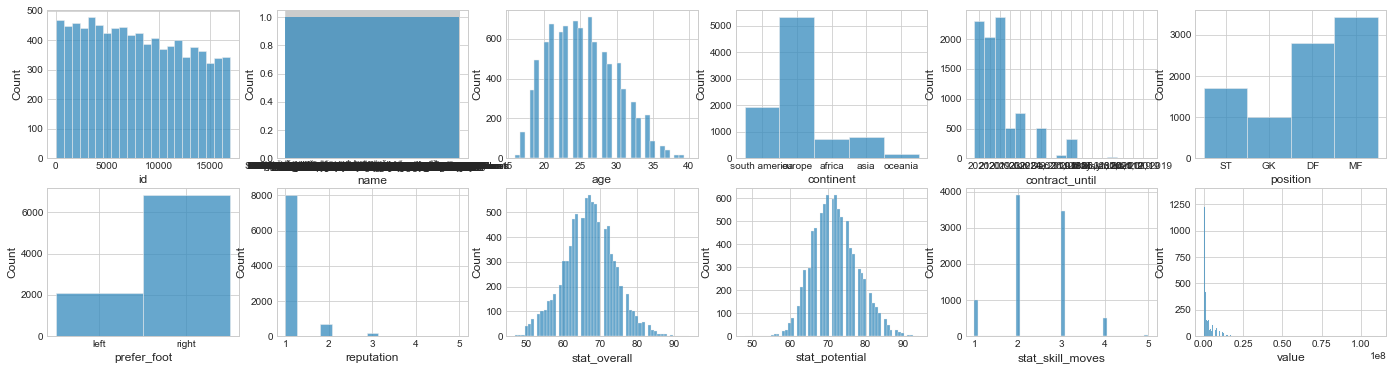

In [9]:
# 히스토그램
# 모든 항목에 대하여. 총 12가지. Label(value)  포함.
f, ax = plt.subplots(2,6, figsize=(24,6))
ax = ax.flatten()
col_list = list(fifa_train.columns)   
print(col_list)
for i in range(len(col_list)):
  sns.histplot(data=fifa_train, x= col_list[i],ax=ax[i])
plt.show()

['continent', 'contract_until', 'position', 'prefer_foot']


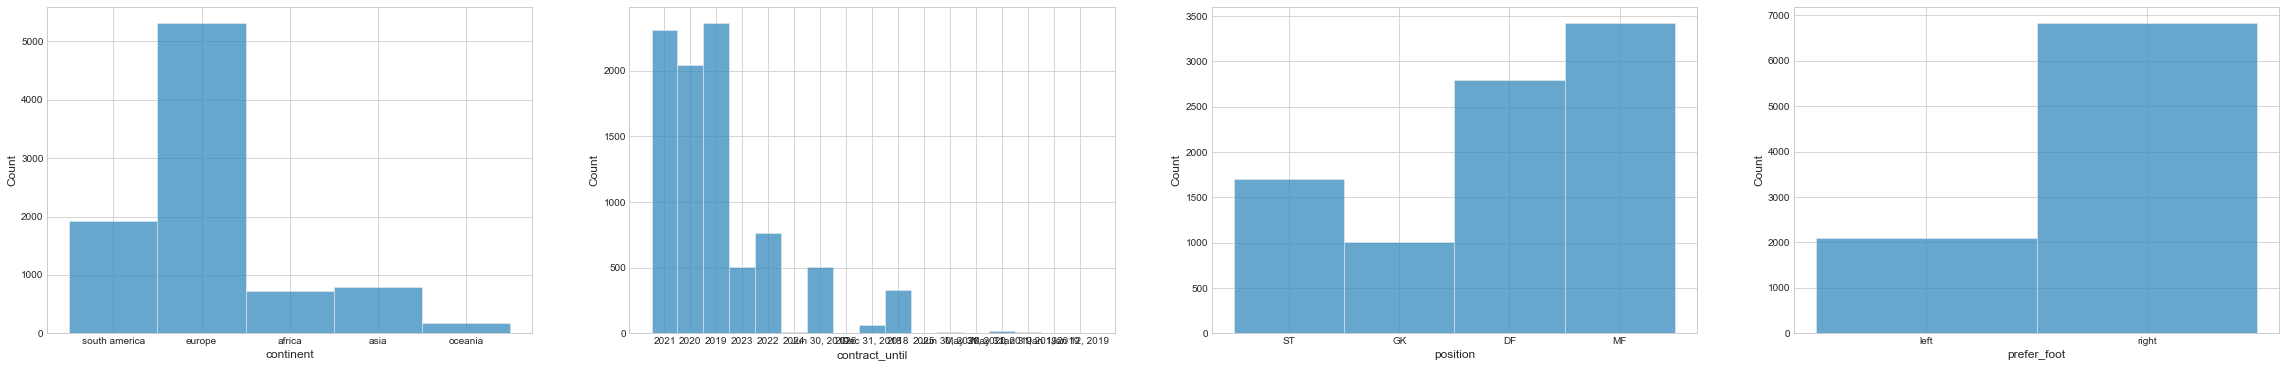

In [10]:
# 히스토그램
# 범주 항목에 대하여. 총 4가지.
f, ax = plt.subplots(1,4, figsize=(40,6))
ax = ax.flatten()
col_list = ["continent","contract_until","position","prefer_foot"]
print(col_list)
for i in range(len(col_list)):
  sns.histplot(data=fifa_train, x= col_list[i],ax=ax[i])
plt.show()

['continent', 'contract_until', 'position', 'prefer_foot']


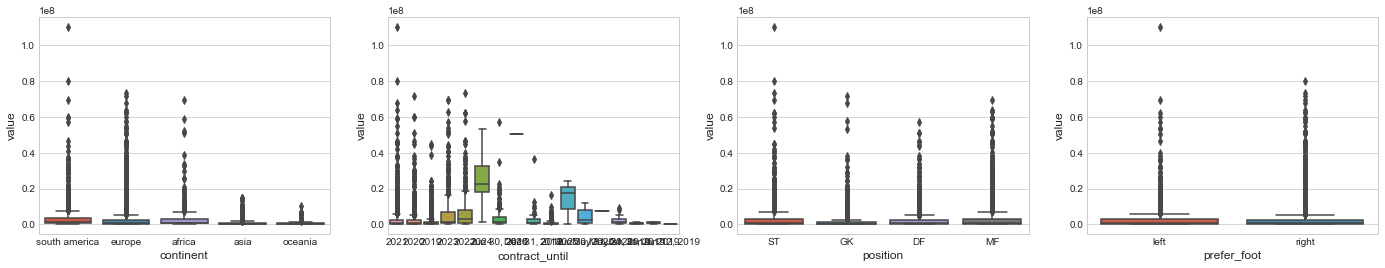

In [11]:
# 박스플롯
# 범주 항목의 가격 연관성에 대하여
f, ax = plt.subplots(1,4, figsize=(24,4))
ax = ax.flatten()
col_list = ["continent","contract_until","position","prefer_foot"]
print(col_list)
for i in range(len(col_list)):
  sns.boxplot(data=fifa_train,x=col_list[i],y="value",ax=ax[i])
plt.show()

['age', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves']


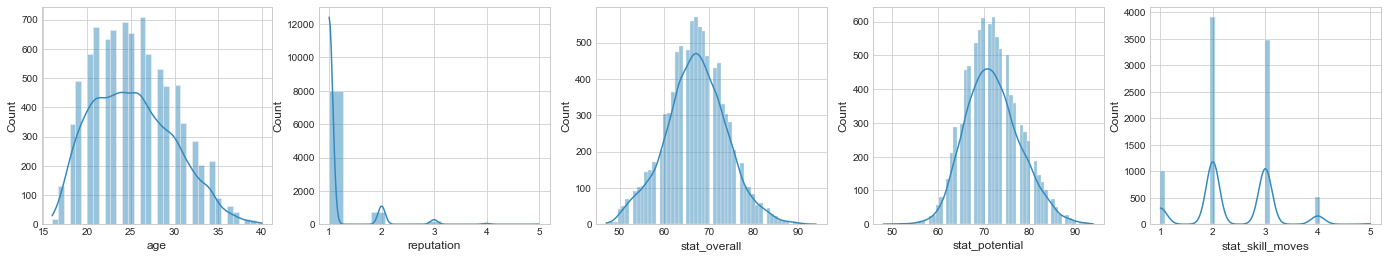

In [12]:
# 히스토그램
# 수치 항목에 대하여, 총 5가지
f, ax = plt.subplots(1,5, figsize=(24,4))
ax = ax.flatten()
col_list = ["age","reputation","stat_overall","stat_potential","stat_skill_moves"]
print(col_list)
for i in range(len(col_list)):
  sns.histplot(data=fifa_train, x= col_list[i],ax=ax[i], kde=True)
plt.show()

['age', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves']


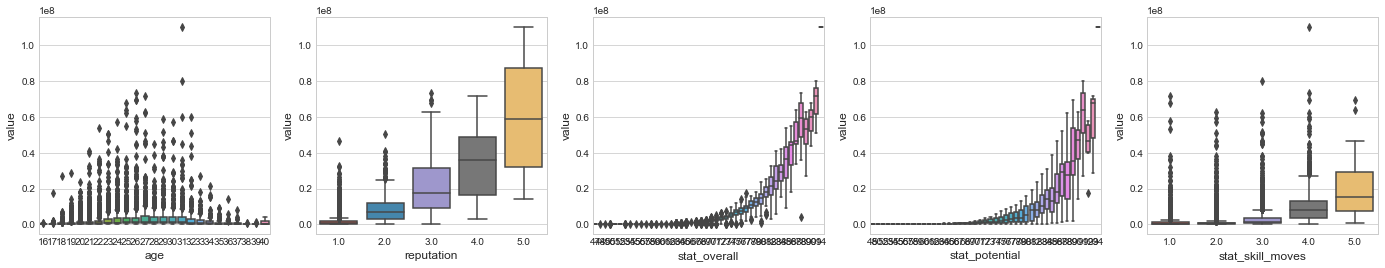

In [13]:
# 박스플롯
# 수치 항목의 가격 연관성에 대하여
f, ax = plt.subplots(1,5, figsize=(24,4))
ax = ax.flatten()
col_list = ["age","reputation","stat_overall","stat_potential","stat_skill_moves"]
print(col_list)
for i in range(len(col_list)):
  sns.boxplot(data=fifa_train,x=col_list[i],y="value",ax=ax[i])
plt.show()

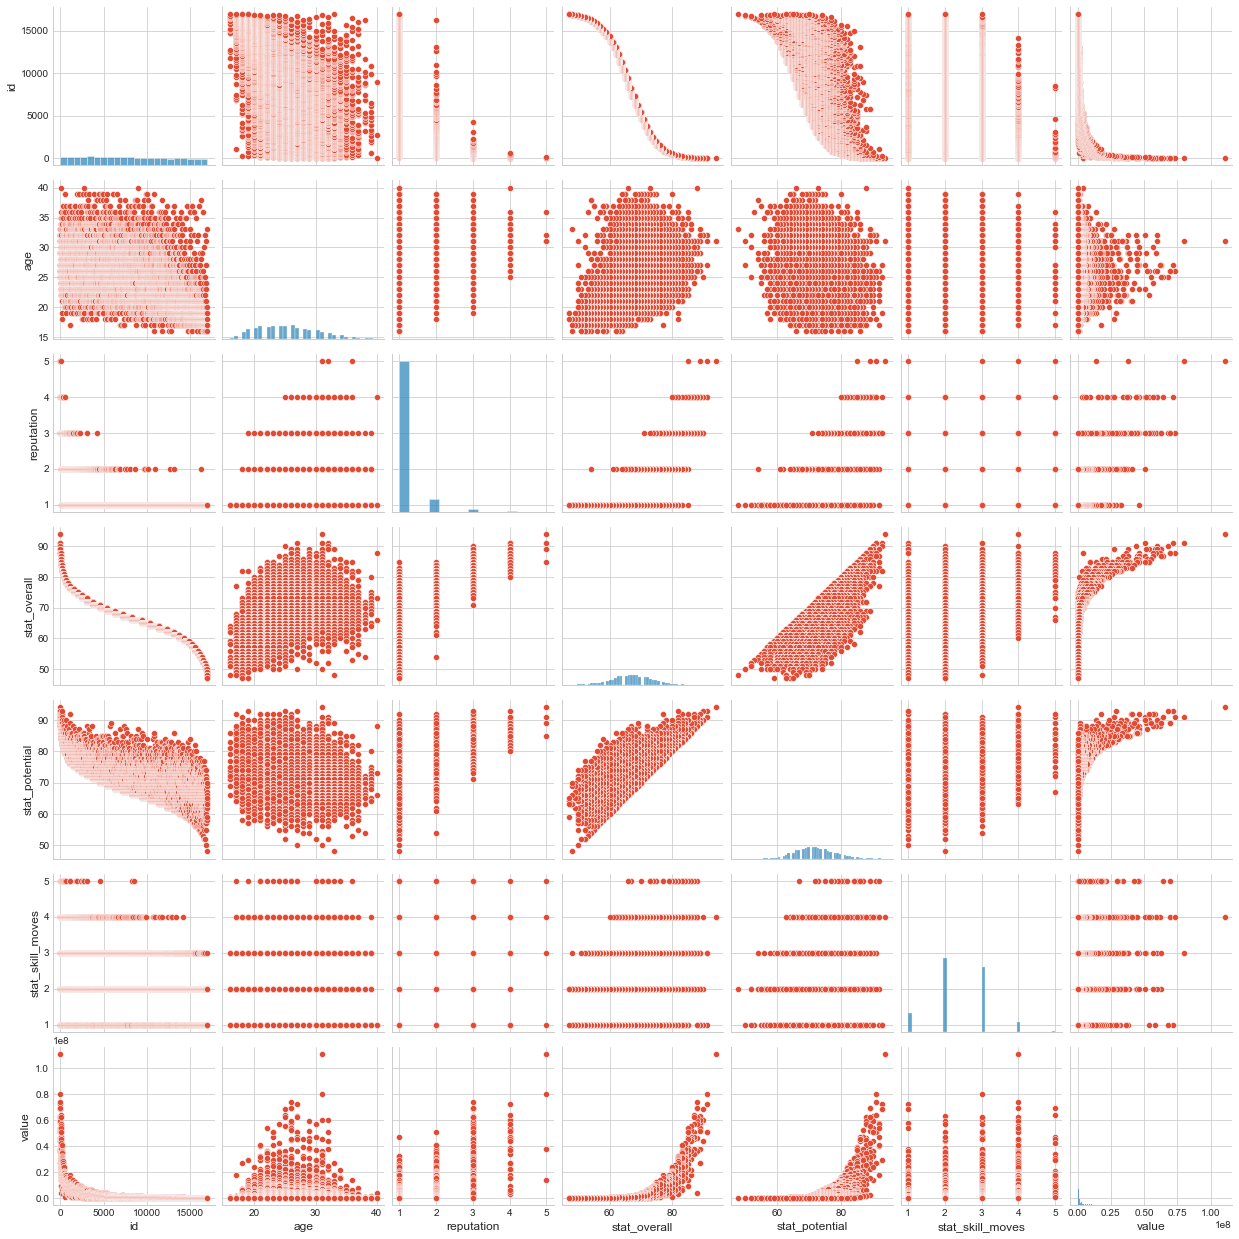

In [14]:
# 페어플롯(여러 변수간 산점도)
sns.pairplot(fifa_train,palette='dark')
plt.show()

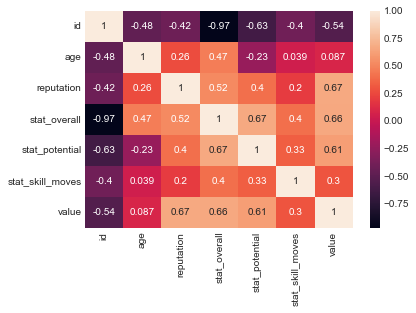

In [15]:
sns.heatmap(fifa_train.corr(), annot=True)
plt.show()

## (2) 데이터 분석 및 수정

### 1) 계약기간 변수 단위 변경

In [16]:
# 반영수치 조정: 월 단위로. 날짜는 반올림.
if transform_contract_until == True:

    def con_period(x):
        if x == 'Dec 31, 2018' :
            return 12
        elif x == 'Jun 30, 2020' :
            return 30
        elif x == 'Jun 30, 2019' :
            return 18
        elif x == 'May 31, 2020' :
            return 29
        elif x == 'May 31, 2019' :
            return 17
        elif x == 'Jan 31, 2019' :
            return 13
        elif x == 'Jan 1, 2019' :
            return 12
        elif x == 'Jan 12, 2019' :
            return 12
        elif x == 'Dec 31, 2019' :
            return 24
        elif x == 'Jun 1, 2019' :
            return 17
        else :
            return (int(x) - 2017)*12
    fifa_train.contract_until = fifa_train.contract_until.apply(con_period).astype('float64')
    fifa_test.contract_until = fifa_test.contract_until.apply(con_period).astype('float64')

# 초기 설정: 년 단위로.
else: 
    def con_period(x):
        if x == 'Dec 31, 2018' :
            return '2019'
        elif x == 'Jun 30, 2020' :
            return '2020.5'
        elif x == 'Jun 30, 2019' :
            return '2019.5'
        elif x == 'May 31, 2020' :
            return '2020.3333'
        elif x == 'May 31, 2019' :
            return '2019.3333'
        elif x == 'Jan 31, 2019' :
            return '2019.0833'
        elif x == 'Jan 1, 2019' :
            return '2019'
        elif x == 'Jan 12, 2019' :
            return '2019.034'
        elif x == 'Dec 31, 2019' :
            return '2020'
        elif x == 'Jun 1, 2019' :
            return '2019.416'
        else :
            return x
    fifa_train.contract_until = fifa_train.contract_until.apply(con_period).astype('float64') - 2018
    fifa_test.contract_until = fifa_test.contract_until.apply(con_period).astype('float64') - 2018

### 2) 'Position' 가중치화

In [17]:
if transform_position == True:
    
    adjusted_position = copy.deepcopy(fifa_train['position'])
    num_st = 0
    num_gk = 0
    num_df = 0
    num_mf = 0
    for i, term in enumerate(adjusted_position):
        if term == 'ST':
            num_st += 1
        elif term == 'GK':
            num_gk += 1
        elif term == 'DF':
            num_df += 1
        elif term == 'MF':
            num_mf += 1
    
    print(f'공격수는 총 {num_st}명입니다.')
    print(f'골키퍼는 총 {num_gk}명입니다.')
    print(f'수비수는 총 {num_df}명입니다.')
    print(f'미드필더는 총 {num_mf}명입니다.')
    total_length = len(adjusted_position)
    print(f'모든 선수의 수는 총 {total_length}명입니다.')
    
    # 공급의 비율: 해당 포지션 선수의 수 / 모든 선수의 수
    supplyratio_st = num_st/total_length
    supplyratio_gk = num_gk/total_length
    supplyratio_df = num_df/total_length
    supplyratio_mf = num_mf/total_length
    print(f'포지션 별 공급 비율: 공격 - {supplyratio_st}, 골키퍼 - {supplyratio_gk}, 수비수 - {supplyratio_df}, 미드필더 - {supplyratio_mf}')
    
    # 수요의 비율: 포메이션 구성에 따라 다르게 수정. (3,5,2), (4,4,2), (3,6,1) 등..
    demandratio_st = formation[2]/11
    demandratio_gk = 1/11
    demandratio_df = formation[0]/11
    demandratio_mf = formation[1]/11
    print(f'포지션 별 수요 비율: 공격 - {demandratio_st}, 골키퍼 - {demandratio_gk}, 수비수 - {demandratio_df}, 미드필더 - {demandratio_mf}')
    
    # 가중치: 수요/공급. 수요가 많으면 가중치 높음.
    weight_st = round((demandratio_st / supplyratio_st), 2)
    weight_gk = round((demandratio_gk / supplyratio_gk), 2)
    weight_df = round((demandratio_df / supplyratio_df), 2)
    weight_mf = round((demandratio_mf / supplyratio_mf), 2)
    print(f'포지션 별 수요/공급 가중치: 공격 - {weight_st}, 골키퍼 - {weight_gk}, 수비수 - {weight_df}, 미드필더 - {weight_mf}')
    
    def replace_position(adjusted_position):
        if adjusted_position == 'ST':
            return weight_st
        elif adjusted_position == 'GK':
            return weight_gk
        elif adjusted_position == 'DF':
            return weight_df
        elif adjusted_position == 'MF':
            return weight_mf
    adjusted_position = adjusted_position.apply(replace_position)

공격수는 총 1705명입니다.
골키퍼는 총 1008명입니다.
수비수는 총 2791명입니다.
미드필더는 총 3428명입니다.
모든 선수의 수는 총 8932명입니다.
포지션 별 공급 비율: 공격 - 0.19088669950738915, 골키퍼 - 0.11285266457680251, 수비수 - 0.31247201074787284, 미드필더 - 0.3837886251679355
포지션 별 수요 비율: 공격 - 0.18181818181818182, 골키퍼 - 0.09090909090909091, 수비수 - 0.2727272727272727, 미드필더 - 0.45454545454545453
포지션 별 수요/공급 가중치: 공격 - 0.95, 골키퍼 - 0.81, 수비수 - 0.87, 미드필더 - 1.18


In [18]:
fifa_train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,3.0,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2.0,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,3.0,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2.0,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,3.0,GK,right,3.0,90,93,1.0,68000000.0


### 3) 'Prefer_foot' 원핫 인코딩화

In [19]:
if transform_prefer_foot == True:
    
    def con_prefoot(x):
            if x == 'left':
                return True
            else :
                return False
            
    fifa_train.prefer_foot = fifa_train.prefer_foot.apply(con_prefoot).astype('float64')
    fifa_test.prefer_foot = fifa_test.prefer_foot.apply(con_prefoot).astype('float64')

In [20]:
fifa_train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,3.0,ST,1.0,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2.0,GK,0.0,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,3.0,ST,0.0,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2.0,DF,0.0,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,3.0,GK,0.0,3.0,90,93,1.0,68000000.0


### 4) 'Age' 피크값 위치 바꾸기

In [21]:
if transform_age == True:
    train_adj_age = []
    test_adj_age = []
    a = 26
    val_point = 15
    
    for i in fifa_train['age']:
        if a - i == 0:
            val_point = 15
            train_adj_age.append(val_point)
    
        elif a < i:
            val_point = 15 - (i-a)
            train_adj_age.append(val_point)
        elif a > i:
            val_point = 15 - (a-i)
            train_adj_age.append(val_point)
    
    fifa_train['age'] = train_adj_age
    
    for i in fifa_test['age']:
        if a - i == 0:
            val_point = 15
            test_adj_age.append(val_point)
    
        elif a < i:
            val_point = 15 - (i-a)
            test_adj_age.append(val_point)
        elif a > i:
            val_point = 15 - (a-i)
            test_adj_age.append(val_point)
    
    fifa_test['age'] = test_adj_age

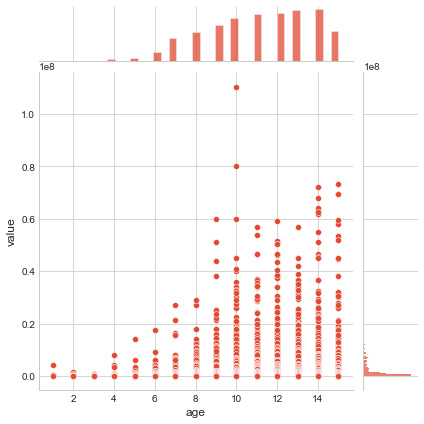

In [22]:
fifa_train.head()
sns.jointplot(data=fifa_train, x="age", y='value')
plt.show()

### 5) 'continent' 제거

In [23]:
if remove_continent == True:
    fifa_train.drop(['continent'], axis = 1, inplace = True)
    fifa_test.drop(['continent'], axis = 1, inplace = True)

In [24]:
fifa_train

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,10,south america,3.0,ST,1.0,5.0,94,94,4.0,110500000.0
1,3,De Gea,14,europe,2.0,GK,0.0,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,10,south america,3.0,ST,0.0,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,9,europe,2.0,DF,0.0,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,14,europe,3.0,GK,0.0,3.0,90,93,1.0,68000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8927,16925,S. Adewusi,7,africa,1.0,MF,0.0,1.0,48,63,3.0,60000.0
8928,16936,C. Ehlich,8,europe,2.0,DF,0.0,1.0,47,59,2.0,40000.0
8929,16941,N. Fuentes,7,south america,3.0,DF,0.0,1.0,47,64,2.0,50000.0
8930,16942,J. Milli,7,europe,3.0,GK,0.0,1.0,47,65,1.0,50000.0


### 6) 'stat_skill_moves' 제거

In [25]:
if remove_stat_skill_moves == True:
    fifa_train.drop(['stat_skill_moves'], axis = 1, inplace = True)
    fifa_test.drop(['stat_skill_moves'], axis = 1, inplace = True)

In [26]:
fifa_train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,10,south america,3.0,ST,1.0,5.0,94,94,4.0,110500000.0
1,3,De Gea,14,europe,2.0,GK,0.0,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,10,south america,3.0,ST,0.0,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,9,europe,2.0,DF,0.0,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,14,europe,3.0,GK,0.0,3.0,90,93,1.0,68000000.0


### 7) 아웃라이어 삭제

In [27]:
if remove_outlier == True:
    sorted_fifa_train = fifa_train.sort_values(by = 'value', ascending = False)

In [28]:
print('정렬된 데이터')
sorted_fifa_train.head()


정렬된 데이터


,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,10,south america,3.0,ST,1.0,5.0,94,94,4.0,110500000.0
2,7,L. Suárez,10,south america,3.0,ST,0.0,5.0,91,91,3.0,80000000.0
17,30,Isco,15,europe,4.0,ST,0.0,3.0,88,91,4.0,73500000.0
1,3,De Gea,14,europe,2.0,GK,0.0,4.0,91,93,1.0,72000000.0
14,26,M. Salah,15,africa,5.0,MF,1.0,3.0,88,89,4.0,69500000.0


In [29]:
sorted_fifa_train.tail()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
8737,16497,F. Nicastro,5,europe,3.0,GK,0.0,1.0,53,53,1.0,10000.0
8534,16043,Y. Nishibe,4,asia,3.0,GK,0.0,1.0,55,55,1.0,10000.0
8274,15465,K. Kitamoto,5,asia,3.0,DF,0.0,1.0,57,57,2.0,10000.0
8158,15182,B. Lekström,4,europe,0.0,GK,0.0,1.0,58,58,1.0,10000.0
8140,15143,C. Månsson,4,europe,0.0,GK,0.0,1.0,58,58,1.0,10000.0


In [30]:
if remove_outlier == True:
    # 아웃라이어 삭제. 
    sorted_fifa_train = sorted_fifa_train.iloc[top_outlier_num:bot_outlier_num]  # 리스트내 구간 수정으로 아웃라이어 구간 설정.
    fifa_train = sorted_fifa_train

In [31]:
print('정렬되고 아웃라이어가 삭제된 데이터')
sorted_fifa_train.head()

정렬되고 아웃라이어가 삭제된 데이터


,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
18,32,Coutinho,15,south america,5.0,ST,0.0,3.0,88,89,5.0,69500000.0
4,9,J. Oblak,14,europe,3.0,GK,0.0,3.0,90,93,1.0,68000000.0
26,45,P. Pogba,14,europe,3.0,MF,0.0,4.0,87,91,5.0,64000000.0
7,14,N. Kanté,14,europe,5.0,MF,0.0,3.0,89,90,2.0,63000000.0
27,47,R. Lukaku,14,europe,4.0,ST,1.0,3.0,87,89,3.0,62500000.0


In [32]:
sorted_fifa_train.tail()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
8737,16497,F. Nicastro,5,europe,3.0,GK,0.0,1.0,53,53,1.0,10000.0
8534,16043,Y. Nishibe,4,asia,3.0,GK,0.0,1.0,55,55,1.0,10000.0
8274,15465,K. Kitamoto,5,asia,3.0,DF,0.0,1.0,57,57,2.0,10000.0
8158,15182,B. Lekström,4,europe,0.0,GK,0.0,1.0,58,58,1.0,10000.0
8140,15143,C. Månsson,4,europe,0.0,GK,0.0,1.0,58,58,1.0,10000.0


## (3) 수정된 데이터 시각화

['id', 'name', 'age', 'continent', 'contract_until', 'position', 'prefer_foot', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves', 'value']


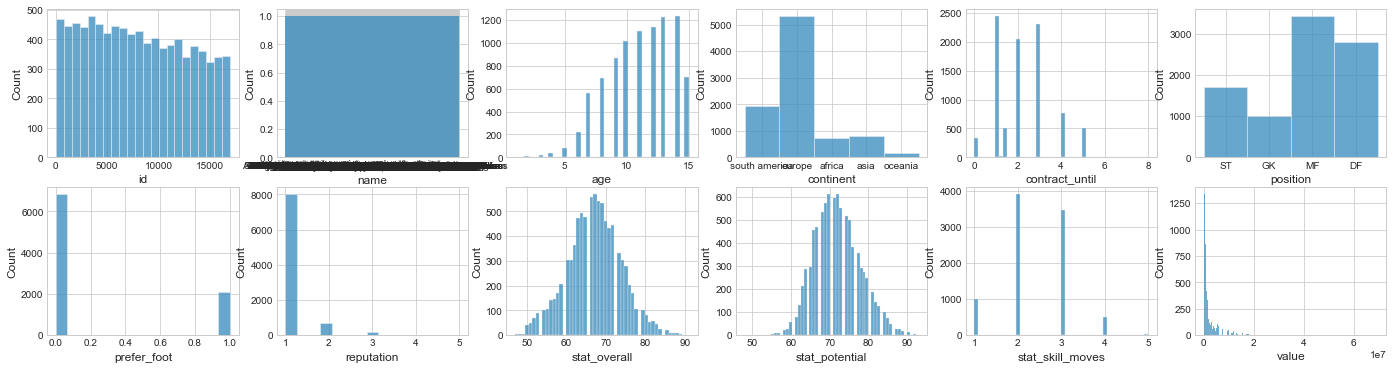

In [33]:
# 히스토그램
# 모든 항목에 대하여. 총 12가지. Label(value)  포함.
f, ax = plt.subplots(2,6, figsize=(24,6))
ax = ax.flatten()
col_list = list(fifa_train.columns)   
print(col_list)
for i in range(len(col_list)):
  sns.histplot(data=fifa_train, x= col_list[i],ax=ax[i])
plt.show()

['continent', 'contract_until', 'position', 'prefer_foot']


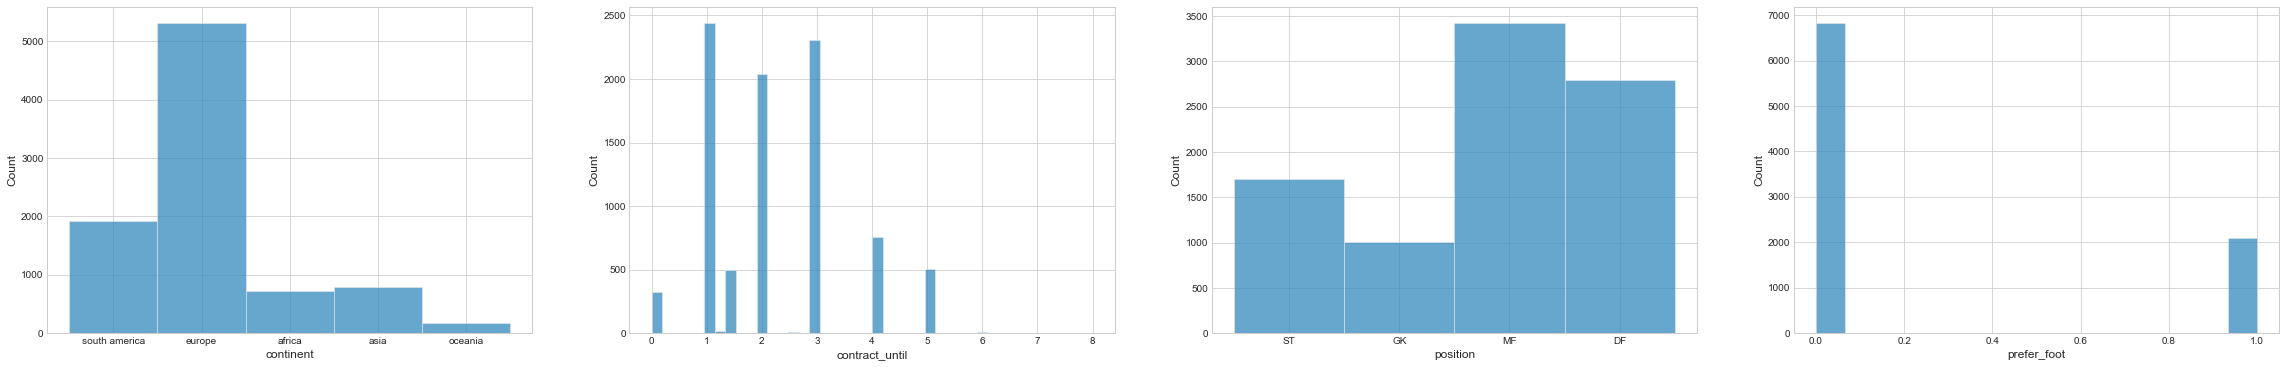

In [34]:
# 히스토그램
# 범주 항목에 대하여. 총 4가지.
f, ax = plt.subplots(1,4, figsize=(40,6))
ax = ax.flatten()
col_list = ["continent","contract_until","position","prefer_foot"]
print(col_list)
for i in range(len(col_list)):
  sns.histplot(data=fifa_train, x= col_list[i],ax=ax[i])
plt.show()

['continent', 'contract_until', 'position', 'prefer_foot']


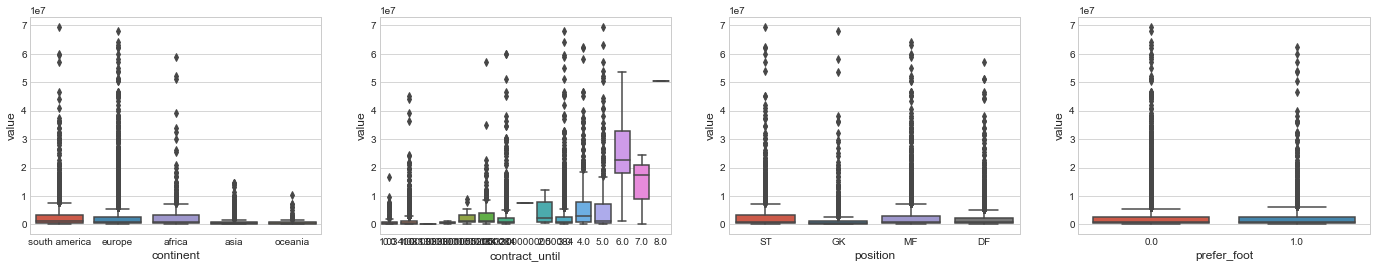

In [35]:
# 박스플롯
# 범주 항목의 가격 연관성에 대하여
f, ax = plt.subplots(1,4, figsize=(24,4))
ax = ax.flatten()
col_list = ["continent","contract_until","position","prefer_foot"]
print(col_list)
for i in range(len(col_list)):
  sns.boxplot(data=fifa_train,x=col_list[i],y="value",ax=ax[i])
plt.show()

['age', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves']


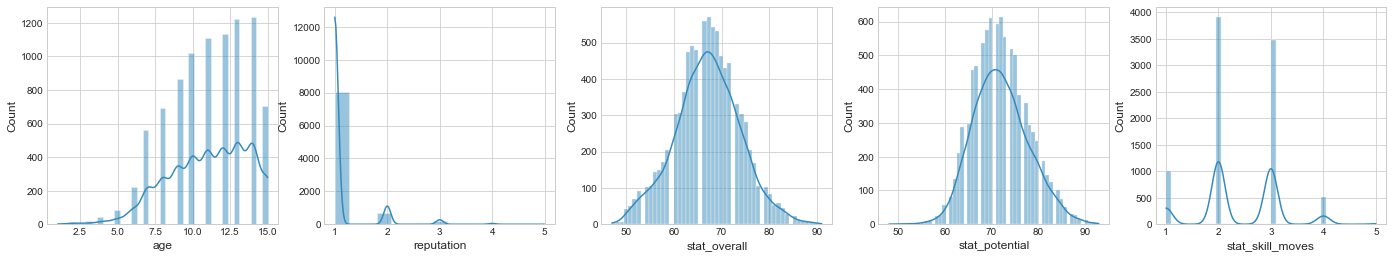

In [36]:
# 히스토그램
# 수치 항목에 대하여, 총 5가지
f, ax = plt.subplots(1,5, figsize=(24,4))
ax = ax.flatten()
col_list = ["age","reputation","stat_overall","stat_potential","stat_skill_moves"]
print(col_list)
for i in range(len(col_list)):
  sns.histplot(data=fifa_train, x= col_list[i],ax=ax[i], kde=True)
plt.show()

['age', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves']


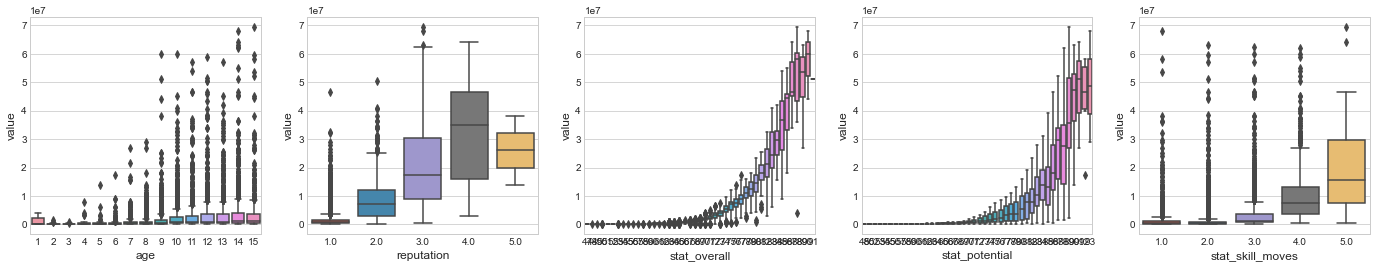

In [37]:
# 박스플롯
# 수치 항목의 가격 연관성에 대하여
f, ax = plt.subplots(1,5, figsize=(24,4))
ax = ax.flatten()
col_list = ["age","reputation","stat_overall","stat_potential","stat_skill_moves"]
print(col_list)
for i in range(len(col_list)):
  sns.boxplot(data=fifa_train,x=col_list[i],y="value",ax=ax[i])
plt.show()

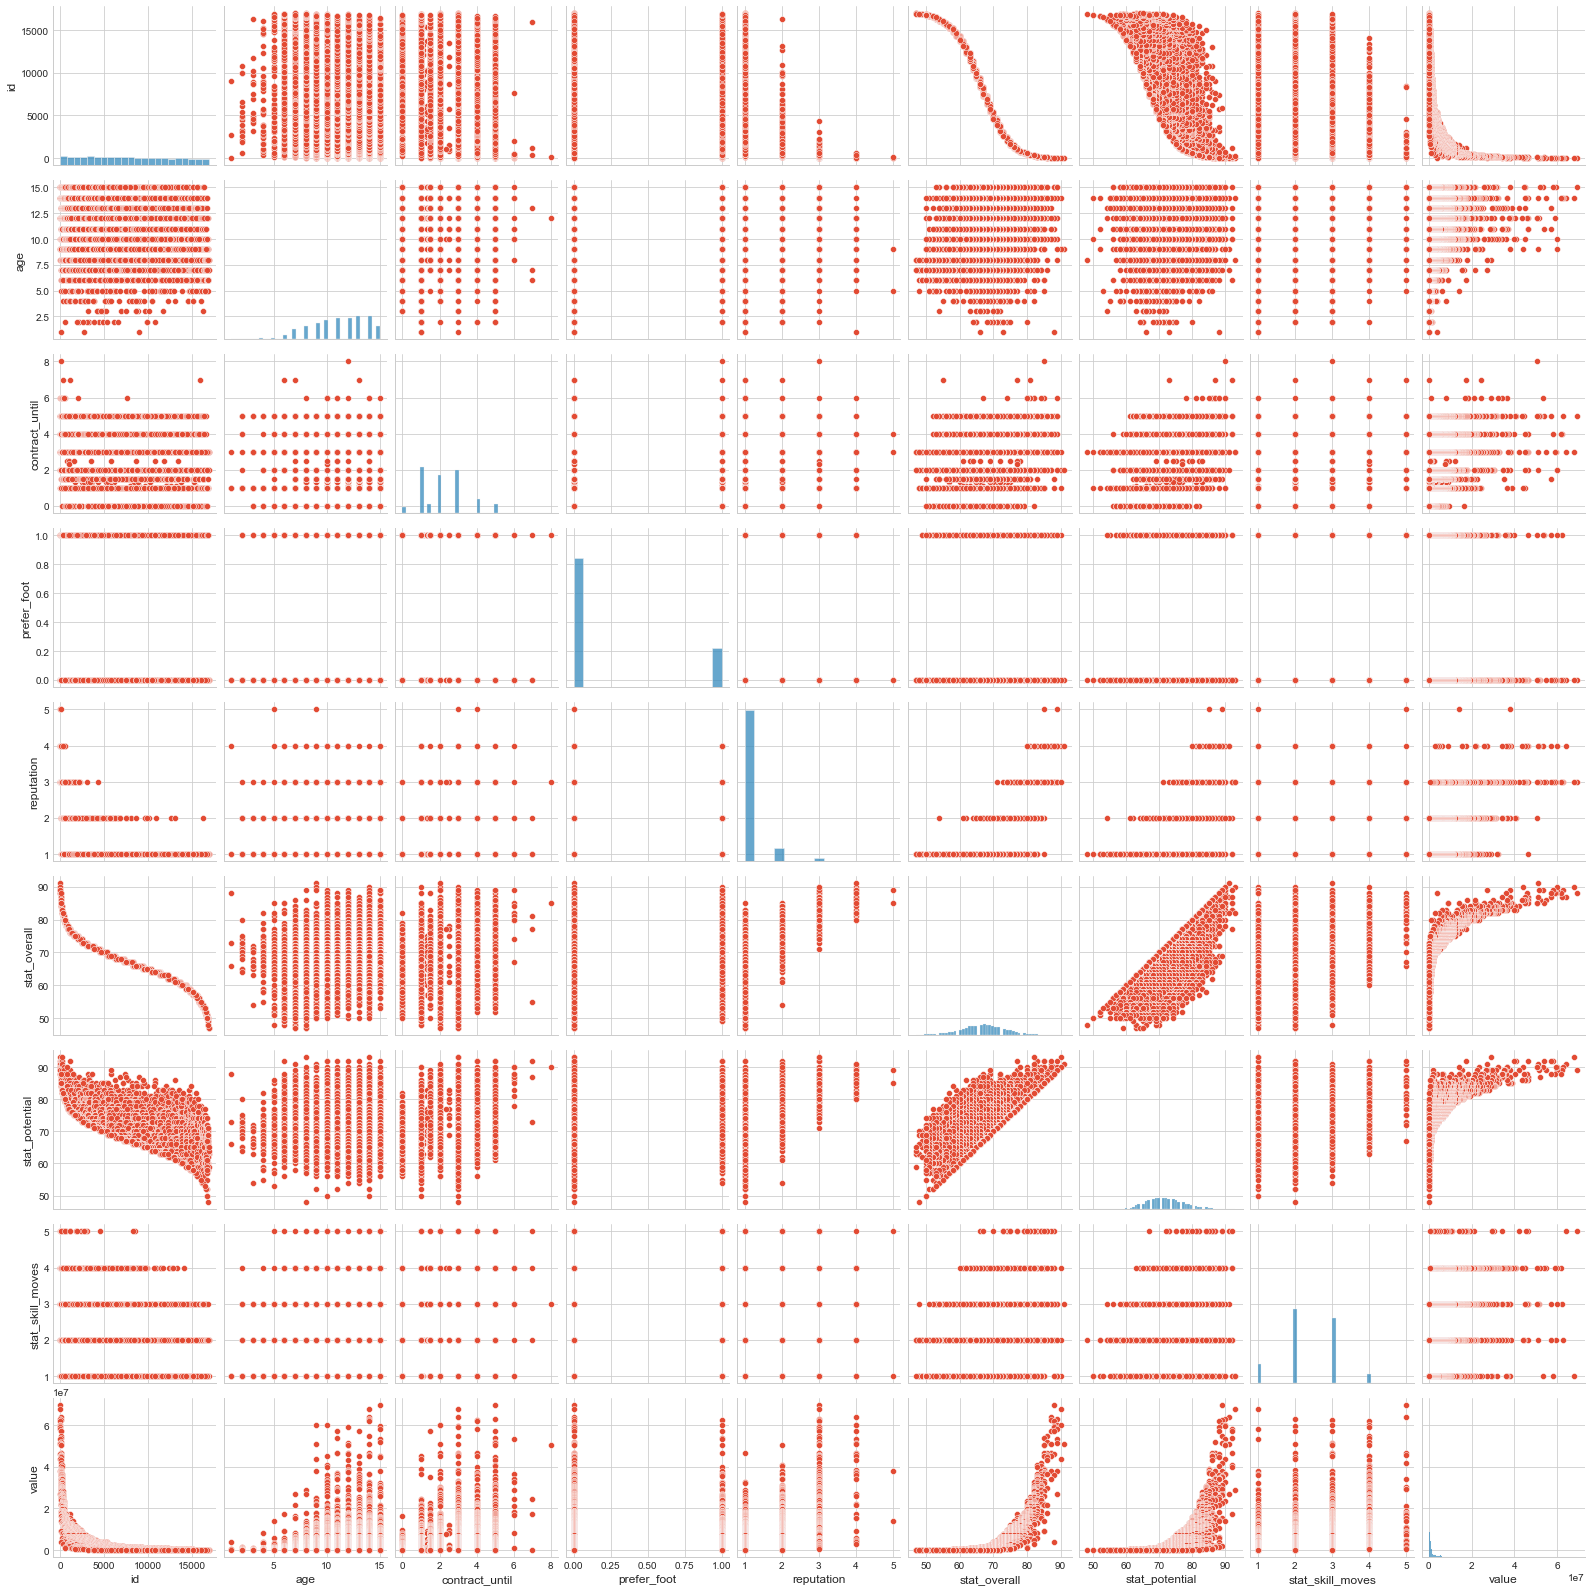

In [38]:
# 페어플롯(여러 변수간 산점도)
sns.pairplot(fifa_train,palette='dark')
plt.show()

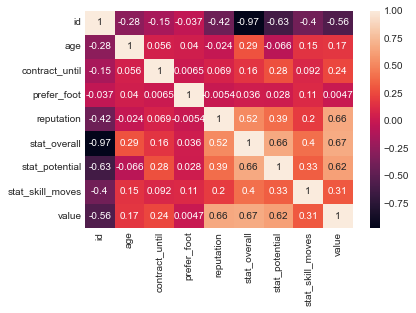

In [39]:
sns.heatmap(fifa_train.corr(), annot=True)
plt.show()

# 3. 훈련 및 평가
## (1) 훈련 전처리

In [40]:
# Log transformation
fifa_train[['contract_until', 'stat_overall', 'stat_potential', 'value']] = np.log1p(fifa_train[['contract_until', 'stat_overall', 'stat_potential', 'value']])
fifa_test[['contract_until', 'stat_overall', 'stat_potential']] = np.log1p(fifa_test[['contract_until', 'stat_overall', 'stat_potential']])

# 훈련 미반영 컬럼 삭제 및 Label 분리
X = fifa_train.drop(['id', 'name', 'value'], axis=1)
y = fifa_train['value']
target = fifa_test.drop(['id', 'name'], axis=1)
#train = X
#target = test

# 범주항목 원핫 인코딩
X = pd.get_dummies(columns = ['continent', 'position'], data = X)
target = pd.get_dummies(columns = ['continent', 'position'], data = target)

## (2) 모델 훈련 - 전체

In [41]:
# 1) NGBRegressor
ngb_pred = np.zeros((target.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    ngb.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in ngb.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(target)]) / 10
    ngb_pred += sub_pred
print(f'{ngb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

[iter 0] loss=1.7554 val_loss=0.0000 scale=1.0000 norm=1.2848
[iter 100] loss=0.7581 val_loss=0.0000 scale=2.0000 norm=1.1162
[iter 200] loss=-0.0982 val_loss=0.0000 scale=2.0000 norm=0.9230
[iter 300] loss=-0.7393 val_loss=0.0000 scale=2.0000 norm=0.8126
[iter 400] loss=-0.9968 val_loss=0.0000 scale=1.0000 norm=0.4254
[iter 0] loss=-1.0558 val_loss=0.0000 scale=1.0000 norm=0.4701
[iter 100] loss=-1.0884 val_loss=0.0000 scale=1.0000 norm=0.4748
[iter 200] loss=-1.1235 val_loss=0.0000 scale=1.0000 norm=0.4750
[iter 300] loss=-1.1474 val_loss=0.0000 scale=2.0000 norm=0.9570
[iter 400] loss=-1.1691 val_loss=0.0000 scale=1.0000 norm=0.4790
[iter 0] loss=-1.1803 val_loss=0.0000 scale=1.0000 norm=0.4869
[iter 100] loss=-1.1989 val_loss=0.0000 scale=1.0000 norm=0.4810
[iter 200] loss=-1.2093 val_loss=0.0000 scale=1.0000 norm=0.4813
[iter 300] loss=-1.2178 val_loss=0.0000 scale=1.0000 norm=0.4814
[iter 400] loss=-1.2372 val_loss=0.0000 scale=1.0000 norm=0.4775
[iter 0] loss=-1.2201 val_loss=0.

In [42]:
# 2) RFRegressor
rf_pred = np.zeros((target.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    rf.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in rf.predict(target)]) / 10
    rf_pred += sub_pred
print(f'{rf.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

RandomForestRegressor의 10fold 평균 RMSE는 636209.0122381819


In [43]:
# 3) ExtraTreeRegressor
etc_pred = np.zeros((target.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    etc.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in etc.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in etc.predict(target)]) / 10
    etc_pred += sub_pred
print(f'{etc.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

ExtraTreesRegressor의 10fold 평균 RMSE는 594388.2147585809


In [44]:
# 4) GradientBosstingRegressor
gb_pred = np.zeros((target.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    gb.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in gb.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in gb.predict(target)]) / 10
    gb_pred += sub_pred
print(f'{gb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

GradientBoostingRegressor의 10fold 평균 RMSE는 473233.07900582737


In [45]:
# 5) CatBoostRegressor
cb_pred = np.zeros((target.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    cb.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in cb.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in cb.predict(target)]) / 10
    cb_pred += sub_pred
print(f'{cb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

CatBoostRegressor의 10fold 평균 RMSE는 508128.21225422295


In [46]:
# 6) LGBMRegressor
lgbm_pred = np.zeros((target.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(target)]) / 10
    lgbm_pred += sub_pred
print(f'{lgbm.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

LGBMRegressor의 10fold 평균 RMSE는 487338.52925157844


In [47]:
# 7) XGBRegressor
xgb_pred = np.zeros((target.shape[0]))
rmse_list = []
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    xgb.fit(tr_x, tr_y)
    pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])

    rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
    rmse_list.append(rmse)
    
    sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(target)]) / 10
    xgb_pred += sub_pred
print(f'{xgb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}')

XGBRegressor의 10fold 평균 RMSE는 519311.6431233896


In [48]:
# Blending models
submission['value'] = (gb_pred + rf_pred + etc_pred + lgbm_pred + cb_pred + ngb_pred + xgb_pred) / 7
q1 = submission['value'].quantile(0.004)
q2 = submission['value'].quantile(0.99)

submission['value'] = submission['value'].apply(lambda x: x if x > q1 else x * 0.9)
submission['value'] = submission['value'].apply(lambda x: x if x < q2 else x * 1.1)

print( "\결과를 기록합니다..." )
submission.to_csv('sub_integrated{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

print( "\n기록 완료.")

\결과를 기록합니다...

기록 완료.
